# ISA Learn Delta

**Motivation:** In the `Supervised-Loss` notebooks, I was also adding what Flo called a "translator loss" to predict the circle (x,y,r). However, this was _not_ quite as easy to learn as I was originally thinking. 
It seemed that before the MSE loss would learn anything, I would run into the unstable training with the losses diverging 

**Motivation:** In the `Supervised-Loss` notebooks, I was also adding what Flo called a "translator loss" to predict the circle (x,y,r). However, this was _not_ quite as easy to learn as I was originally thinking. 
It seemed that before the MSE loss would learn anything, I would run into the unstable training with the losses diverging.

<img src="figures/mse-sa-sept23.png"/>

**Thoughts:** However, (especially in the ISA paradigm), I do have a first representation of the center of mass (com) and spread of the slots, so I could _use this_ to just learn the position and radius as the correction to the current slot com and radius. 

**Note:** This is exactly what Lukas's global pflow [paper](https://arxiv.org/abs/2212.01328) did, in their hypergraph approach... so I guess we're just slowly building towards a solution :)

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('../code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from torch.nn import init
from train import hungarian_matching #train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
device='cuda:1'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':128,
    'pixel_mult':0.2,
    'device':device
}

In [3]:
class HyperGraphISA(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 varlow=0.01,
                 varhigh=0.05,
                 k_slots=3, 
                 num_conv_layers=3,
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block, block attention
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        self.rlow, self.rhigh = np.sqrt(varlow), np.sqrt(varhigh)
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)
        
        '''
        CNN feature extractor
        '''
        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
        cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
        # Grid + query init
        self.abs_grid = self.build_grid()
                   
        self.dense = torch.nn.Linear(2, query_dim) 
        self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

        # Apply after the data normalization
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(query_dim,query_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(query_dim,query_dim)
        )
            
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

        
        '''
        Option to add a final (x,y,r) prediction to each slot
        '''
        self.learn_slot_feat = True
        if self.learn_slot_feat:
            self.final_mlp = torch.nn.Sequential(
                torch.nn.Linear(query_dim,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, 3)
            )
        
    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        
        grid = torch.FloatTensor( grid ).to(self.device)
        grid = torch.flatten(grid,1,2)
    
        return grid
                
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        
        stdhigh, stdlow = self.rlow, self.rhigh
        
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
        queries = mu + sigma * torch.randn(mu.shape,device=device)
    
        # Add the position and scale initialization for the local ref frame
        ref_frame_dim = 3
        pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=device)

        pos_scale[:,:2] -= 0.5
        pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
        return queries, pos_scale
     
    def get_keys_vals(self, encoded_data, pos_scale):

        # Get the relative position embedding
        rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
        rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
        # Embed it in the same space as the query dimension 
        embed_grid = self.pixel_mult * self.dense( rel_grid )
        
        # keys, vals: (bs, img_dim, query_dim)
        keys = m.toK(encoded_data).unsqueeze(1) + embed_grid
        vals = m.toV(encoded_data).unsqueeze(1) + embed_grid
        
        keys = self.init_mlp(self.queryN(keys))
        vals = self.init_mlp(self.queryN(vals))
        
        return keys, vals
                
    def attention_and_weights(self,queries,keys):
        
        logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def update_frames(self,wts):
        '''
        Update the relative frame position
        '''
        
        # expand to include the batch dim
        grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
        new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
        new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
        new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
        new_scale = torch.sqrt(new_scale)
        
        return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
    def iterate(self, queries, pos_scale, encoded_data):
        
        # Get the keys and values in the ref ref frame
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
        new_pos_scale = self.update_frames(wts)
        
        # Update the queries with the recurrent block
        updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape), new_pos_scale
        
    def forward(self, data):
    
        '''
        Step 1: Extract the CNN features
        '''
        encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
        encoded_data = self.dataN(encoded_data)
        
        '''
        Step 2: Initialize the slots
        '''
        Nbatch = data.shape[0]
        queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
                
        '''
        Step 3: Iterate through the reconstruction
        '''
        for i in range(self.n_iter):
            queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        att, wts = self.attention_and_weights(self.queryN(queries),keys)   
        new_pos_scale = self.update_frames(wts)
                
        if self.learn_slot_feat:
            slot_feat = self.final_mlp(queries)
            
            # Want to learn the delta from the previously estimated position
            slot_feat += new_pos_scale
            
            return queries, att, slot_feat 
        
        else:
            return queries, att, wts

In [4]:
m = HyperGraphISA(**hps).to(device)

In [5]:
m.device = device
m = m.to(device)

In [6]:
device

'cuda:1'

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    for k,v in losses.items():
        axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    if figname:
        plt.savefig(figname)

    plt.show()
    plt.close()

In [8]:
def comb_loss(att,flat_mask,Y=None,Y_pred=None,alpha=1):
    '''
    Goal: Given a NN that predicts both an occupancy mask
    and a center and radius for each slot, combine these terms 
    into a combined loss function:
    
    L = L_bce + alpha * L_mse
    
    Note: This function should be general enough to either calculate
    the losses of all the combinations of slots and targets or just
    the single loss between the loss and the chosen target
        
    '''
    
    max_n_rings = flat_mask.shape[1]
    k_slots = att.shape[1]
    
    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
    
    l_bce = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    
    if alpha == 0:
        return l_bce
    
    else:
    
        # Calc MSEmse_loss(Y,Y_pred)
        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred.unsqueeze(2), Y.unsqueeze(1)).mean(axis=-1)
        return l_bce + alpha * l_mse
    

In [9]:
# Invaraint Slot Attention, Hyper Graph
cID = 'isa-hg'

modelDir = f'../code/models/{cID}'
figDir = f'../code/figures/{cID}'

for d in [modelDir,figDir]:
    if not os.path.exists(d):
        os.mkdir(d)

In [10]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'bce':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
         
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
        
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_bce + alpha*l_mse
        
        li.backward()
        clip_val=1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['bce'].append(float(l_bce))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
            iEvt = 0

            # losses, mask, att_img, Y_true, Y_pred
            plot_chosen_slots(losses,
                              mask[iEvt].sum(axis=0), 
                              slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                              Y_true_sorted[iEvt],
                              Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 1, 2, 3])) that is different to the input size (torch.Size([256, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter 100 , loss 0.8847598 , lr 2.9999537364671845e-05


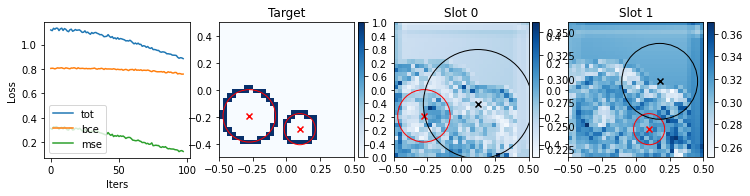

iter 200 , loss 0.5886829 , lr 5.999629897444982e-05


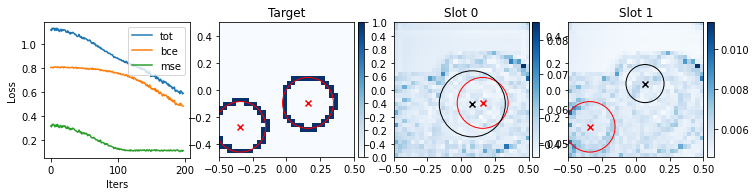

iter 300 , loss 0.19919157 , lr 8.998750935981002e-05


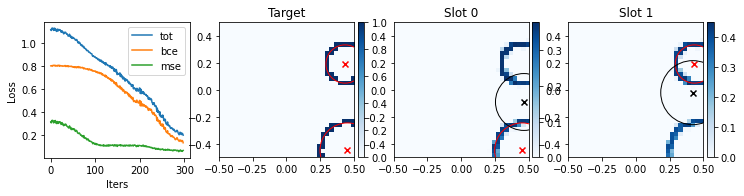

iter 400 , loss 0.1776363 , lr 0.0001199703936219439


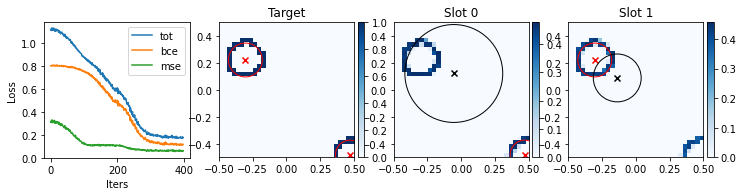

iter 500 , loss 0.17214122 , lr 0.00014994217771805422


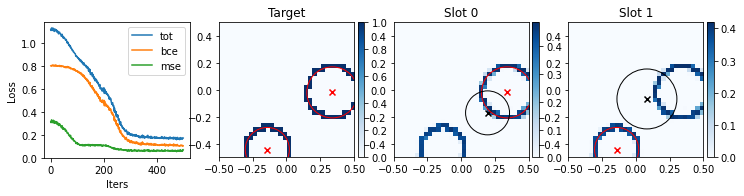

iter 600 , loss 0.17338881 , lr 0.0001799000887465773


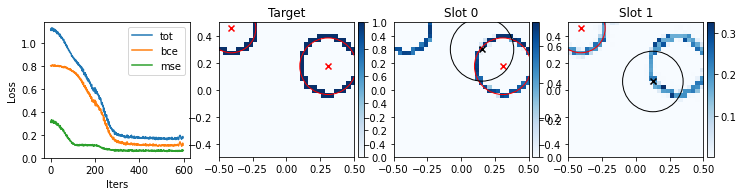

iter 700 , loss 0.17430894 , lr 0.00020984135523230646


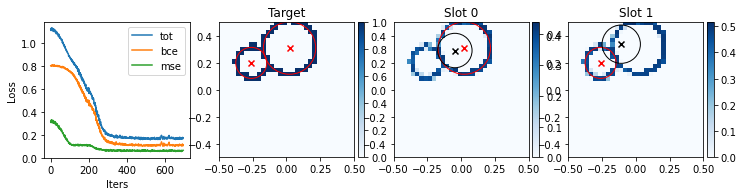

iter 800 , loss 0.15835902 , lr 0.00023976320741139257


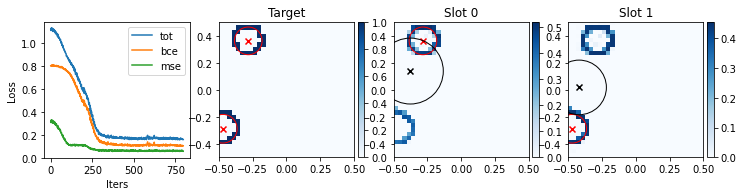

iter 900 , loss 0.1598238 , lr 0.0002696628775161965


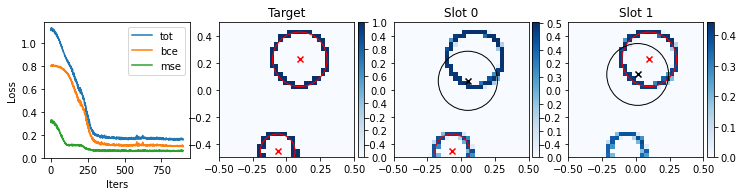

iter 1000 , loss 0.15863875 , lr 0.00029953760005996916


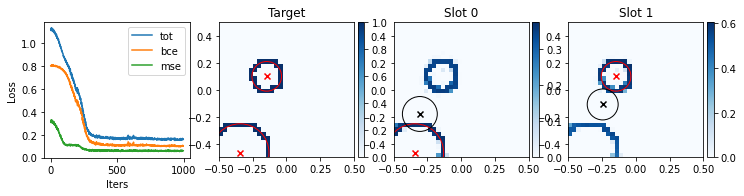

iter 1100 , loss 0.15307233 , lr 0.00029944055647394114


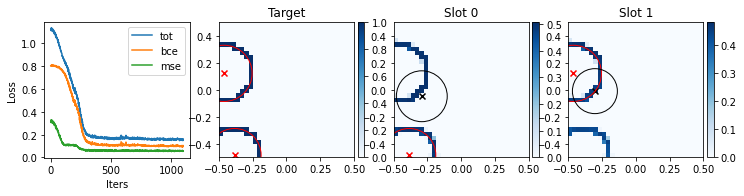

iter 1200 , loss 0.15455195 , lr 0.000299334294690462


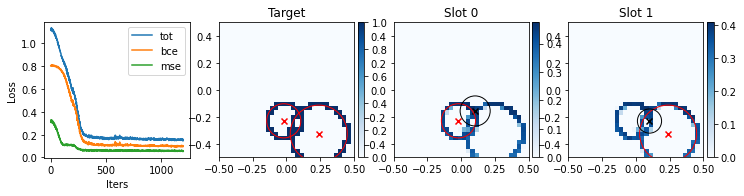

iter 1300 , loss 0.15774903 , lr 0.00029921882126425893


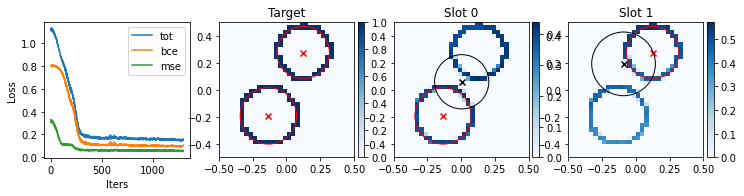

iter 1400 , loss 0.15178677 , lr 0.00029909414331827697


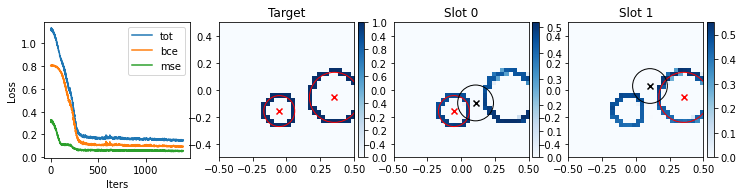

iter 1500 , loss 0.1382716 , lr 0.00029896026854323894


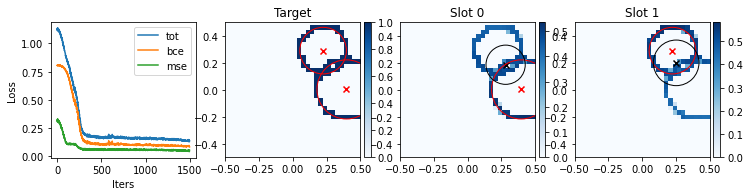

iter 1600 , loss 0.1274326 , lr 0.0002988172051971717


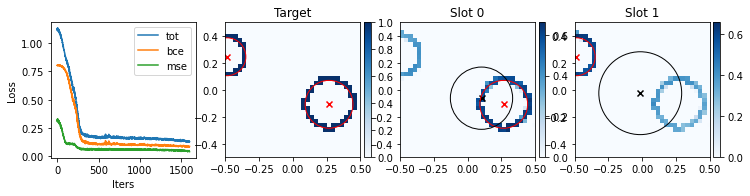

iter 1700 , loss 0.12546143 , lr 0.0002986649621048962


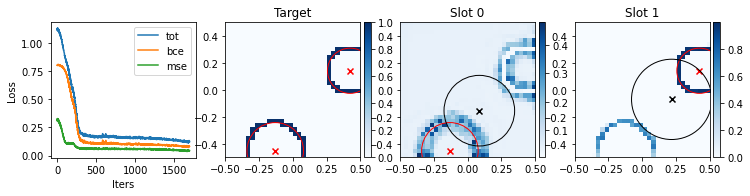

iter 1800 , loss 0.109320134 , lr 0.0002985035486574836


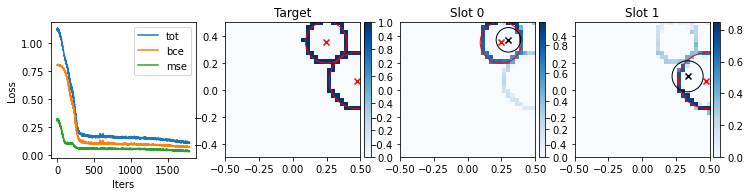

iter 1900 , loss 0.11063378 , lr 0.00029833297481167566


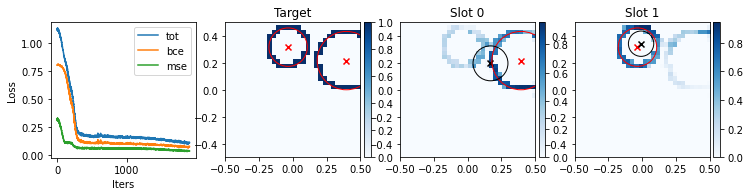

iter 2000 , loss 0.09578172 , lr 0.00029815325108927063


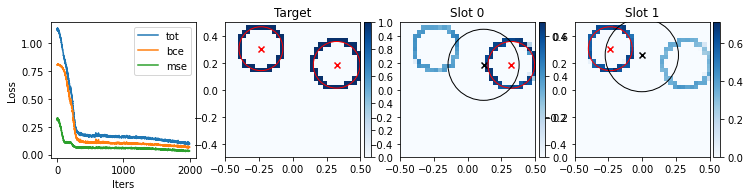

iter 2100 , loss 0.093464114 , lr 0.0002979643885764743


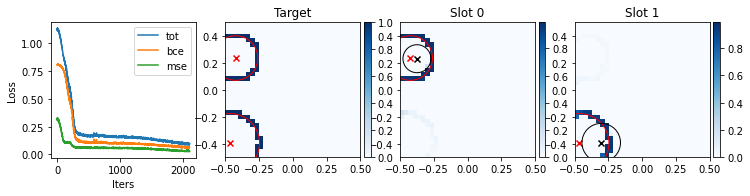

iter 2200 , loss 0.08525105 , lr 0.00029776639892321606


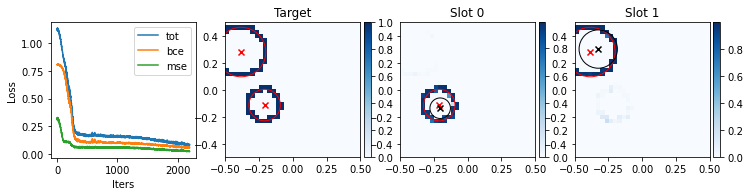

iter 2300 , loss 0.07796763 , lr 0.00029755929434243034


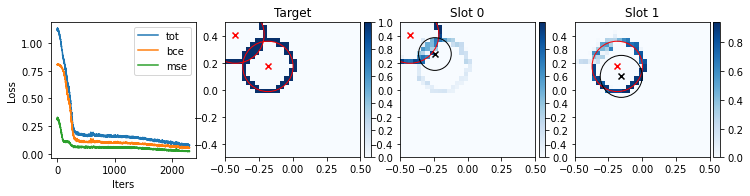

iter 2400 , loss 0.06897333 , lr 0.0002973430876093033


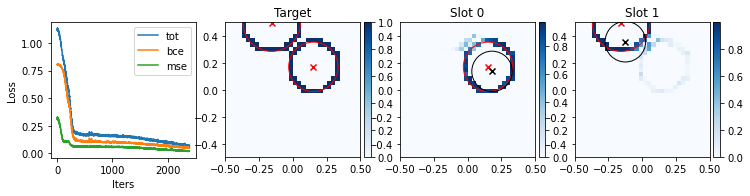

iter 2500 , loss 0.0655879 , lr 0.00029711779206048454


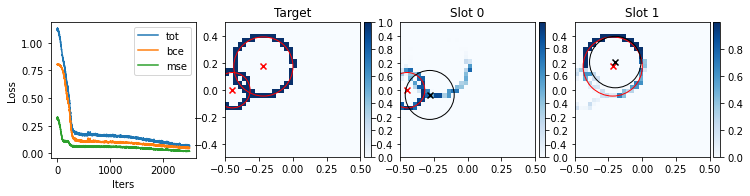

iter 2600 , loss 0.055029273 , lr 0.0002968834215932648


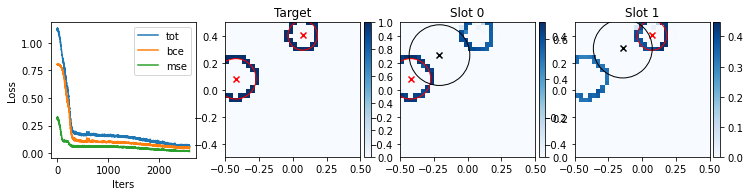

iter 2700 , loss 0.07803645 , lr 0.00029663999066471857


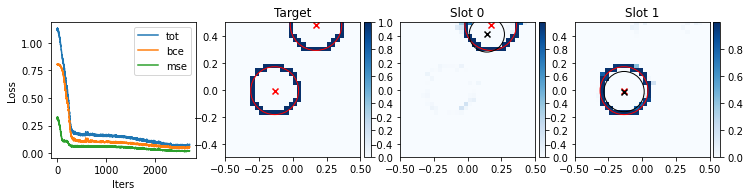

iter 2800 , loss 0.057077035 , lr 0.0002963875142908121


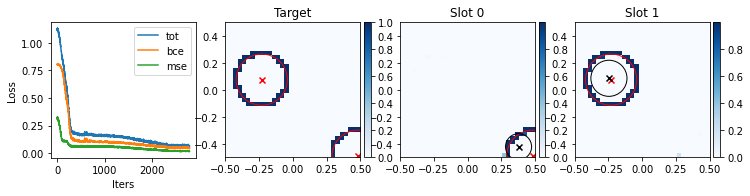

iter 2900 , loss 0.05583127 , lr 0.0002961260080454774


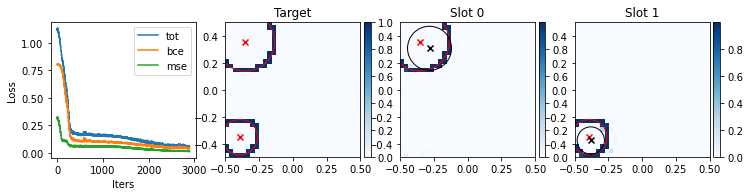

iter 3000 , loss 0.06701444 , lr 0.0002958554880596515


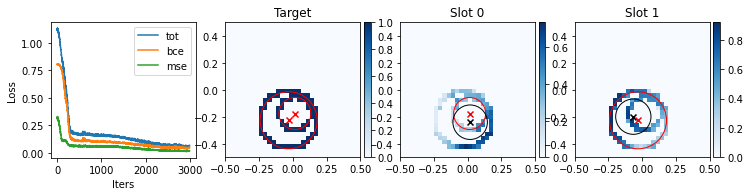

iter 3100 , loss 0.052031714 , lr 0.00029557597102028134


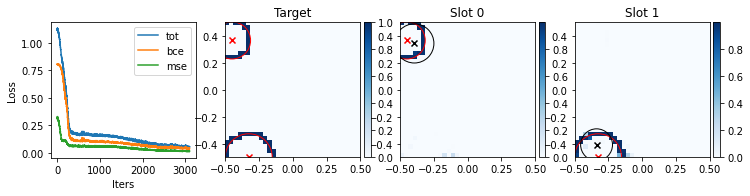

iter 3200 , loss 0.059958756 , lr 0.00029528747416929463


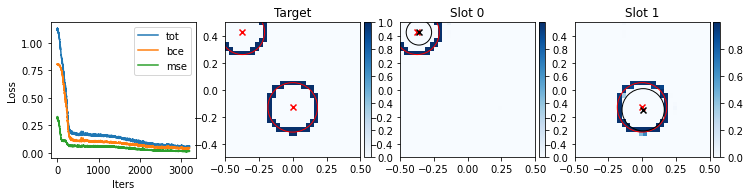

iter 3300 , loss 0.05524308 , lr 0.00029499001530253606


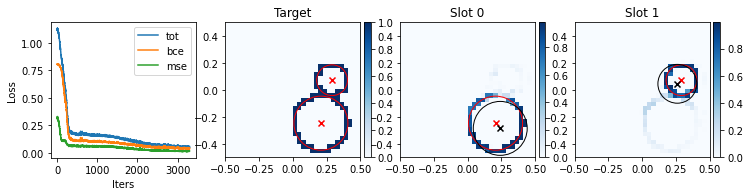

iter 3400 , loss 0.05245829 , lr 0.0002946836127686697


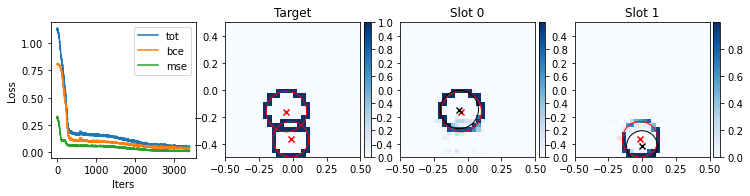

iter 3500 , loss 0.045028593 , lr 0.000294368285468047


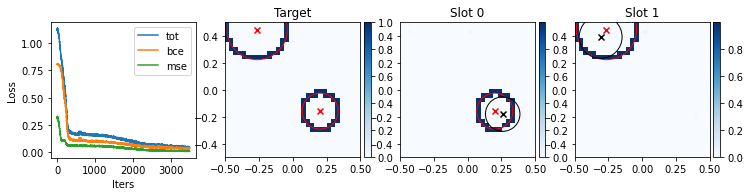

iter 3600 , loss 0.04828158 , lr 0.0002940440528515414


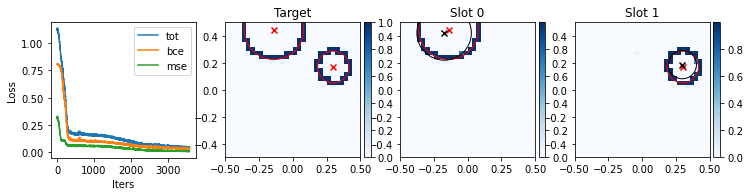

In [ ]:
m, losses = train(m, bs=256, Ntrain=40_000, warmup_steps=1_000,
                  plot_every=100, device=device,
                  modelDir=modelDir,figDir=figDir)

In [ ]:
# bs=2
# kwargs={'isRing': True, 'N_clusters':2}
# X, Y, mask = make_batch(N_events=bs, **kwargs,device=device)

# max_n_rings=2
# resolution=(32,32)
# alpha=1

In [ ]:
# queries, att, Y_pred = m(X)

# # Reshape the target mask to be flat in the pixels (same shape as att)
# flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
# with torch.no_grad():

#     pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
#     indices = hungarian_matching(pairwise_cost)

# # Apply the sorting to the predict
# bis=torch.arange(bs).to(device)
# indices=indices.to(device)

# # Loss calc
# slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
# rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
# l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

# Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
# Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

# l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()

# # Calculate the loss
# li = l_bce + alpha*l_mse

# li.backward()
# clip_val=1
# torch.nn.utils.clip_grad_norm_(m.parameters(), clip_val)

# # opt.step()
# # opt.zero_grad()
# losses = {'tot':[],'bce':[],'mse':[]}
# losses['tot'].append(float(li))
# losses['bce'].append(float(l_bce))
# losses['mse'].append(float(l_mse))
# i=0
# if i % 100 == 0:
#     print('iter',i,', loss',li.detach().cpu().numpy(),', lr',0)#opt.param_groups[0]['lr'])

#     iEvt = 0
#     att_sorted  = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

#     att_img = att_sorted[iEvt].reshape(max_n_rings,*resolution)

#     plot_chosen_slots(losses,mask[iEvt].sum(axis=0), att_img,
#                       rings_sorted[iEvt],slots_sorted[iEvt])

**Notes:**

In [ ]:
iEvt = 0

fig, ax = plt.subplots(1,3,figsize=(10,2.5))

extent = [-0.5,0.5]*2
for i_slot, (axi,li,qi) in enumerate(zip(ax,logits[iEvt],
                                         queries[iEvt].detach().numpy())):
    
    im = axi.imshow(li.reshape(32,32).detach().numpy(),
                    cmap='PuOr',vmax=.05,vmin=-.05,
                    extent=extent,origin='lower')

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    
    axi.scatter(*qi[:2],marker='x',color='cyan')
    circle = Circle(qi[:2],np.exp(qi[2]),fill=False,color='cyan')
    axi.add_patch(circle)
        
for axi,yi in zip(ax,Y[iEvt]):
    axi.scatter(*yi[:2],marker='x',color='r')
    circle = Circle(yi[:2],yi[2],fill=False,color='r')
    axi.add_patch(circle)
    
    axi.set_xlim(-0.5,0.5)
    axi.set_ylim(-0.5,0.5)
    
plt.show()